>本篇涉及部分高等数学知识,如插值、拟合、微积分、有约束优化以及无约束优化，建议先结合代码与图解以理解概念为主，若是理解起来有些吃力可以暂且放下，只需了解到"SciPy库为解决科学计算相关问题提供了诸多专用函数"这个知识点即可,当有余力时或具体需求时再对相关数学原理做进一步研究和探索.

SciPy 是 Python 里处理科学计算 (scientific computing) 的包，使用它遇到问题可访问它的官网 (https://www.scipy.org/). 去找答案。

下面用科学计算中的三个具体问题来介绍SciPy库.当SciPy库中有很多类似的专用函数,这里只是以使用频率较高的三个函数来说明SciPy库的使用场景和具体方法.我们先来导入SciPy库和相关package,然后再对其进行一一说明.

In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate as spi  # 插值专用函数
import scipy.integrate as sci  # 积分专用函数
import scipy.optimize as spo  # 优化专用函数

# 插值

我先通俗地解释下什么是插值.想象一长串离散的点分布在坐标轴中,各点的值是已知的,也就是说给出一个x就有一个y与之对应,但如果我想求得点与点之间的某个值怎么办?插值就是专门用来解决这个问题的

给定一组 (xi, yi)，其中 i = 1, 2, ..., n，而且 xi 是有序的，称为「标准点」。插值就是对于任何新点 xnew，计算出对应的 ynew。换句话来说，插值就是在标准点之间建立分段函数 (piecewise function)，把它们连起来。这样给定任意连续 x 值，带入函数就能计算出任意连续 y 值。

在 SciPy 中有个专门的函数 scipy.interpolate (interpolate即"插入、篡改") 是用来插值的

In [2]:
x = np.linspace(-2 * np.pi, 2 * np.pi, 11)
f = lambda x: np.sin(x) + 0.5 * x
f(x)

array([-3.14159265, -1.56221761, -1.29717034, -1.84442231, -1.57937505,
        0.        ,  1.57937505,  1.84442231,  1.29717034,  1.56221761,
        3.14159265])

介绍下面知识之前,若你对样条曲线的概念不是很了解,可以参考下[样条曲线](https://baike.baidu.com/item/%E6%A0%B7%E6%9D%A1%E6%9B%B2%E7%BA%BF)

scipy.interpolate中有个非常有名的哼哈二将:splrep和splev.这"哥俩",一个用来生成样条曲线,另一个用来根据前者生成的曲线做估值.

splrep 和 splev 像是组合拳 (one two punch)

- 前者将 x, y 和插值方式转换成「样条对象」tck
- 后者利用它在 xnew 上生成 ynew

In [3]:
tck = spi.splrep(x, f(x), k=1)
tck

(array([-6.28318531, -6.28318531, -5.02654825, -3.76991118, -2.51327412,
        -1.25663706,  0.        ,  1.25663706,  2.51327412,  3.76991118,
         5.02654825,  6.28318531,  6.28318531]),
 array([-3.14159265, -1.56221761, -1.29717034, -1.84442231, -1.57937505,
         0.        ,  1.57937505,  1.84442231,  1.29717034,  1.56221761,
         3.14159265,  0.        ,  0.        ]),
 1)

tck 就是样条对象，以元组形式返回，tck 这名字看起来很奇怪，实际指的是元组 (t, c, k) 里的三元素.假如你使用过PS之类软件的话,其中钢笔工具的数学原理就是样条曲线,对此应当不会陌生.

- t - vector of knots (节点)
- c - spline cofficients (系数)
- k - degree of spline (阶数)


对照上面的输出值可以看到，tck 确实一个元组，包含两个 array 和一个标量 1，其中

- 第一个 array 是节点，即标准点，注意到一开始 x 只有 11 个，但现在是 13 个，首尾都往外补了一个和首尾一样的 x

- 第二个 array 是系数，注意它就是 y 在尾部补了两个 0

- 标量 1 是阶数，因为在调用 splrep 时就把 k 设成 1

In [4]:
# 求插值
iy = spi.splev(x, tck)
iy

array([-3.14159265, -1.56221761, -1.29717034, -1.84442231, -1.57937505,
        0.        ,  1.57937505,  1.84442231,  1.29717034,  1.56221761,
        3.14159265])

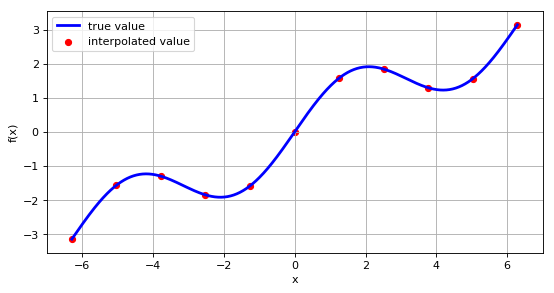

In [7]:
# 利用matplotlib进行可视化
plt.figure(figsize=(8, 4), dpi=80)
x_ = np.linspace(-2 * np.pi, 2 * np.pi, 1000)
plt.plot(x_, f(x_), color='blue', linewidth=2.5, label='true value')
plt.scatter(x, iy, 30, color='red', label='interpolated value')
plt.legend(loc=0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [9]:
# 用具体数值结果来评估插值效果
np.allclose(f(x), iy)
np.sum((f(x) - iy)**2) / len(x)

0.0

以上例子其实是在标准点上插值,就好像自己跟自己比,只是为了便于理解,下面用一个实例做进一步说明

[ 1.          1.04081633  1.08163265  1.12244898  1.16326531  1.20408163
  1.24489796  1.28571429  1.32653061  1.36734694  1.40816327  1.44897959
  1.48979592  1.53061224  1.57142857  1.6122449   1.65306122  1.69387755
  1.73469388  1.7755102   1.81632653  1.85714286  1.89795918  1.93877551
  1.97959184  2.02040816  2.06122449  2.10204082  2.14285714  2.18367347
  2.2244898   2.26530612  2.30612245  2.34693878  2.3877551   2.42857143
  2.46938776  2.51020408  2.55102041  2.59183673  2.63265306  2.67346939
  2.71428571  2.75510204  2.79591837  2.83673469  2.87755102  2.91836735
  2.95918367  3.        ] 

,iyd


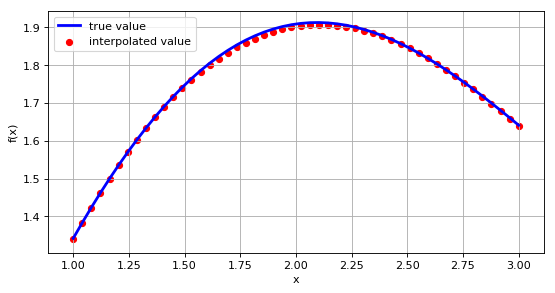

In [10]:
xd = np.linspace(1, 3, 50)
iyd = spi.splev(xd, tck)
tck = spi.splrep(x, f(x), k=3)
iyd = spi.splev(xd, tck)
print(xd, '\n\n,iyd')
plt.figure(figsize=(8, 4), dpi=80)
plt.plot(xd, f(xd), color='blue', linewidth=2.5, label='true value')
plt.scatter(xd, iyd, 30, color='red', label='interpolated value')
plt.legend(loc=0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [11]:
# 评估插值
np.sum(f(xd) - iyd**2) / len(xd)

-1.3483156243298016

另外,这里提供一份有关插值和拟合的资料,希望有助于你对相关数学原理的理解[插值和拟合](Book/插值和拟合.pdf)

# 积分

在 SciPy 中有个专门的函数 scipy.integrate 是用来做数值积分的,下面我们利用这个函数来了解对函数求积分的操作

In [13]:
f = lambda x: np.sin(x) + 0.5 * x

$$\int_{0.5}^{9.5} (sin(x)+0.5x)dx = [-cos(x) + 0.25x^2] \mid_{0.5}^{9.5} =24.37475471808675 $$

假设我们想从 x= 0.5 到 9.5 对 f(x) 求积分，可以手推出

在 scipy.integrate 里还有些数值积分的函数：

- fixed_quad：fixed Gaussian quadrature (定点高斯积分)

- quad：adaptive quadrature (自适应积分)

- romberg：Romberg integration (龙贝格积分)

- trapz：用 trapezoidal 法则

- simps：用 Simpson’s 法则

其中,前三个函数 fixed_quad, quad, romberg 的参数是被积函数、下界和上界;对后两个函数 trapz 和 simps，首先在上下界之间取 n 个点 xi，再求出对应的函数值 f(xi)，再把当参数 f(xi) 和 xi 传到函数中

In [19]:
sci.fixed_quad(f, 0.5, 9.5)[0]

24.366995967084602

In [20]:
sci.quad(f, 0.5, 9.5)[0]

24.374754718086752

In [21]:
sci.romberg(f, 0.5, 9.5)

24.374754718086713

In [22]:
xi = np.linspace(0.5, 9.5, 100)
sci.trapz(f(xi), xi)

24.373463386819818

In [23]:
sci.simps(f(xi), xi)

24.374740115484069

quad 的结果最精确。一般当被积函数不规则时 (某段函数值激增)，quad (自适应积分) 的结果也是最好。

这里给出一些关于微积分的基础资料,通过这些资料我们可以基本搞明白什么是导数、微分、积分以及相互间的关系。其中资料1是以现代极限概念推导出微积分基本公式，比较抽象，所以理解起来需要花费功夫；资料2是介绍以无穷小量作为基础推导出微积分基本公式的古典微积分作为开始，相对来说容易理解些，但古典微积分存在一个致命缺陷，即以无穷小量推出导数会存在切线与曲线交线不止一个点与切线与曲线交于一点时不存在切线的矛盾，这也是后来发展处现代微积分先确定导数再去推到微分的原因，从此微积分体系才重新做到了“自圆其说”。

[1.微分、导数、积分三者的联系](https://www.zhihu.com/question/264955988)

[2.微分、积分、微积分、导数之详细辨别](https://zhuanlan.zhihu.com/p/38337248)

# 优化

在 SciPy 中有个专门的函数 scipy.optimize 是用来优化的,下面我们用求函数$ sin(x) + 0.5x^2 + sin(y) +0.05y^2 $的最小值

In [24]:
# 首先定义函数
f = lambda x, y: np.sin(x) + 0.05 * x**2 + np.sin(y) + 0.05 * y**2

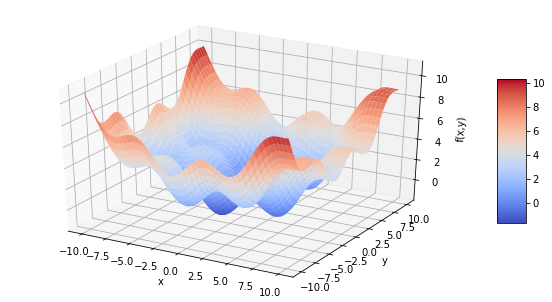

In [26]:
f = lambda x, y: np.sin(x) + 0.05 * x**2 + np.sin(y) + 0.05 * y**2

from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(-10, 10, 50)
y = np.linspace(-10, 10, 50)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

fig = plt.figure(figsize=(8, 4))
ax = Axes3D(fig)

surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

不难看出该函数有多个局部最小值 (local minimum) 和一个全局最小值 (global minimum)。我们目标是求后者，主要步骤如下：

- 在 (x-y) 定义域上选点，求出函数值 f(x, y)，找出最小值对应的 x* 和 y*
- 用 x* 和 y* 当初始值，求出函数全局最小值

## 第一步:用蛮力找函数最小值以及对应的参数

brute("蛮干"的意思) 是scipy.optimize中一个常用函数,它要求用一个元组把若干参数集合起来,通过将函数、参数元组扔进brute中可以得到该函数的最小值以及对应的参数值

In [30]:
# 定义测试函数
def fo(xy):
    x, y = xy
    z = np.sin(x) + 0.05 * x**2 + np.sin(y) + 0.05 * y**2
    if output == True:
        print('{} {} {}'.format(x, y, z))
    return z

In [32]:
output = True
rranges = ((-10, 10, 5), (-10, 10, 5))
spo.brute(fo, rranges, finish=None)

-10 -10 11.088042221778739
-10 -10 11.088042221778739
-10 -5 7.752945385552508
-10 0 5.5440211108893696
-10 5 5.835096836226231
-5 -10 7.752945385552509
-5 -5 4.417848549326277
-5 0 2.2089242746631386
-5 5 2.5
0 -10 5.5440211108893696
0 -5 2.2089242746631386
0 0 0.0
0 5 0.29107572533686155
5 -10 5.835096836226231
5 -5 2.5
5 0 0.29107572533686155
5 5 0.5821514506737231


array([ 0.,  0.])

In [36]:
# 替换成更小的步长
output = False
rranges = ((-10, 10, 0.1), (-10, 10, 0.1))
opt1 = spo.brute(fo, rranges, finish=None)
print(opt1)
print(fo(opt1))

[-1.4 -1.4]
-1.77489945998


当步长变小，我们能在更细的网格上计算函数值，这是函数在 (-1.4, -1.4) 取最小值 -1.7749，明显比函数在 (0, 0) 上的值 0 要小。

## 第二步:把参数当初始值,求函数全局最小值

其实如果网格足够密，上面 -1.7749 大概率是全局最小值而  (-1.4, -1.4) 是对应的最优解.但出于数学严谨性,我们不能以经验做直接判断,而是采用"最坏打算"的原则,假设网格不是足够密，那么以 (-1.4, -1.4) 当初始值，进而大概率找到全局最小值。

用 fmin 函数，将刚才 opt1 传进去，并设定 x 和 f 的终止条件 xtol 和 ftol，和最多迭代次数 maxiter 和最多运行函数次数 maxfun。

In [37]:
output = True
opt2 = spo.fmin(fo, opt1, xtol=0.001, ftol=0.001, maxiter=15, maxfun=20)
print(opt2)

-1.4000000000000004 -1.4000000000000004 -1.7748994599769203
-1.4700000000000004 -1.4000000000000004 -1.774329079766041
-1.4000000000000004 -1.4700000000000004 -1.7743290797660412
-1.3300000000000003 -1.4700000000000006 -1.7695827276986251
-1.4350000000000005 -1.4175000000000004 -1.7756403866946224
-1.4350000000000005 -1.3475000000000004 -1.7722175692069706
-1.4087500000000004 -1.4393750000000005 -1.7754569915832503
-1.4437500000000005 -1.4568750000000006 -1.7751135039067365
-1.4328125000000007 -1.4426562500000006 -1.7755861787931349
-1.4590625000000008 -1.4207812500000006 -1.7751589553124218
-1.4213281250000005 -1.4347265625000005 -1.7756764959744498
-1.4235156250000003 -1.4095703125000005 -1.7755407435528803
-1.4304882812500006 -1.4343847656250006 -1.775695506287223
-1.4168164062500006 -1.4516113281250007 -1.7753471595488823
-1.4304541015625005 -1.4260278320312505 -1.7757197974424463
-1.4396142578125009 -1.4256860351562504 -1.77564443394365
-1.4258996582031256 -1.4324664306640629 -1.7

In [38]:
output = False
print(fo(opt2))

-1.77572469922


比刚才函数在 (-1.4, -1.4) 取的最小值 -1.7749 又小了一些。注意好的初始值对求函数的最优解影响比较大,而我们可以通过brute函数解决寻找初始值的问题.